# **Loan Approval Prediction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
df = pd.read_csv('loan_approval_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (4269, 13)

First 5 rows:
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_


Loan Status Distribution:
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Approval Rate: 0.00%


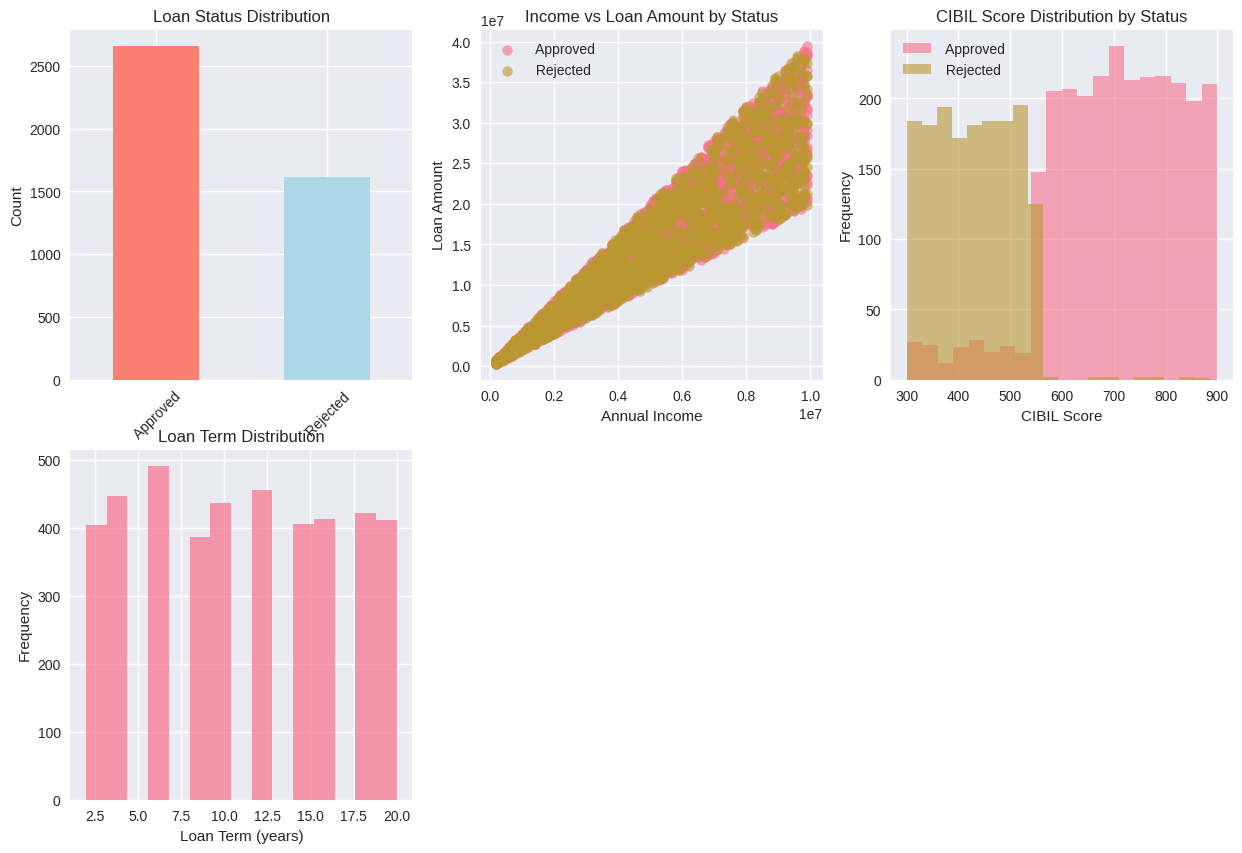

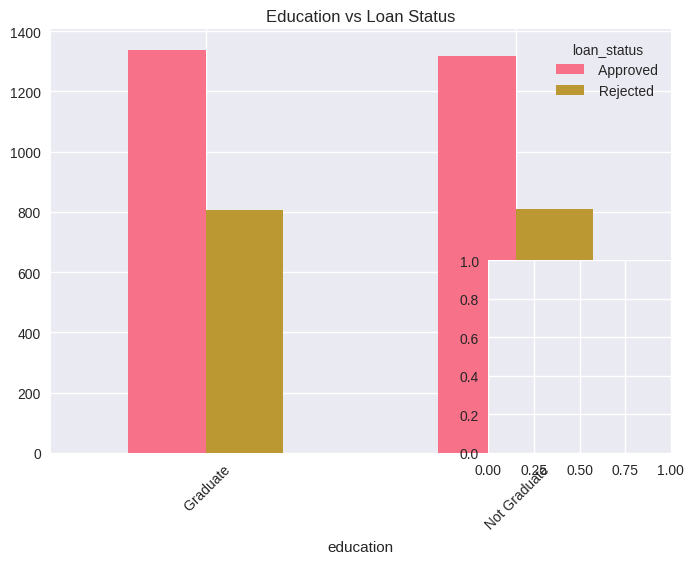

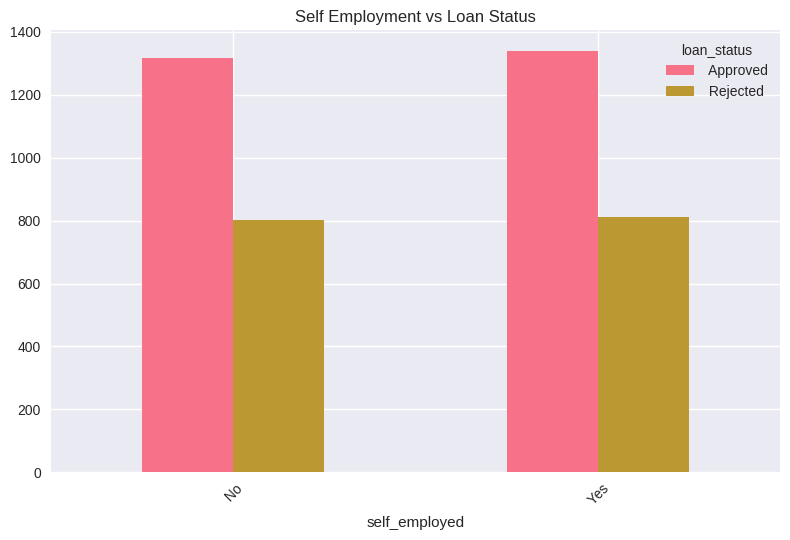

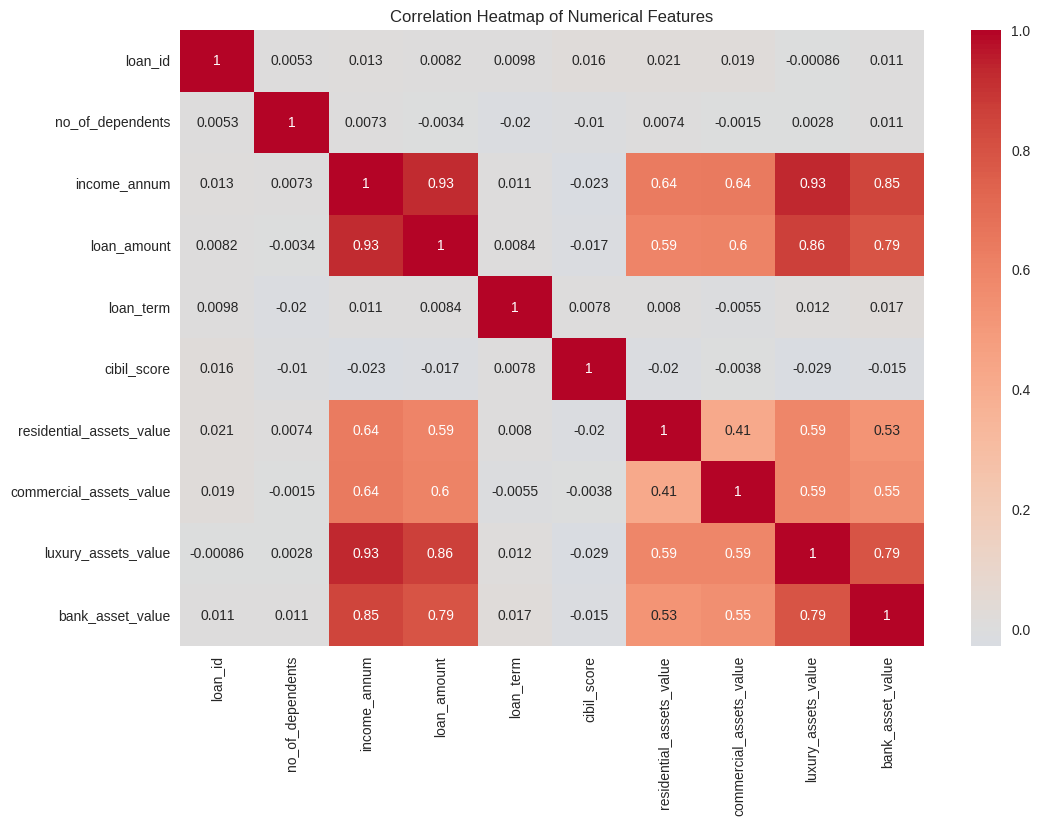

In [22]:
# Check target variable distribution
print("\nLoan Status Distribution:")
print(df['loan_status'].value_counts())
print(f"\nApproval Rate: {(df['loan_status'] == 'Approved').mean():.2%}")

# Visualize target distribution
plt.figure(figsize=(15, 10))

# Target distribution
plt.subplot(2, 3, 1)
df['loan_status'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'])
plt.title('Loan Status Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Income vs Loan Amount by Status
plt.subplot(2, 3, 2)
for status in df['loan_status'].unique():
    subset = df[df['loan_status'] == status]
    plt.scatter(subset['income_annum'], subset['loan_amount'],
               label=status, alpha=0.6)
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.title('Income vs Loan Amount by Status')
plt.legend()

# CIBIL Score distribution
plt.subplot(2, 3, 3)
for status in df['loan_status'].unique():
    subset = df[df['loan_status'] == status]
    plt.hist(subset['cibil_score'], alpha=0.6, label=status, bins=20)
plt.xlabel('CIBIL Score')
plt.ylabel('Frequency')
plt.title('CIBIL Score Distribution by Status')
plt.legend()

# Loan Term distribution
plt.subplot(2, 3, 4)
df['loan_term'].hist(bins=15, alpha=0.7)
plt.xlabel('Loan Term (years)')
plt.ylabel('Frequency')
plt.title('Loan Term Distribution')

# Education vs Loan Status
plt.subplot(2, 3, 4)
pd.crosstab(df['education'], df['loan_status']).plot(kind='bar')
plt.title('Education vs Loan Status')
plt.xticks(rotation=45)

# Self Employment vs Loan Status
plt.subplot(2, 3, 6)
pd.crosstab(df['self_employed'], df['loan_status']).plot(kind='bar')
plt.title('Self Employment vs Loan Status')
plt.xticks(rotation=45)



plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [23]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values (if any)
print("Checking for missing values...")
missing_values = df_processed.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values found:")
    print(missing_values[missing_values > 0])

    # Fill numerical missing values with median
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    df_processed[numerical_cols] = df_processed[numerical_cols].fillna(
        df_processed[numerical_cols].median()
    )

    # Fill categorical missing values with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'loan_status':
            df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])
else:
    print("No missing values found!")

# Feature Engineering
print("\nCreating new features...")

# Debt-to-Income Ratio
df_processed['debt_to_income_ratio'] = df_processed['loan_amount'] / df_processed['income_annum']

# Total Assets Value
df_processed['total_assets_value'] = (df_processed['residential_assets_value'] +
                                     df_processed['commercial_assets_value'] +
                                     df_processed['luxury_assets_value'] +
                                     df_processed['bank_asset_value'])

# Asset-to-Loan Ratio
df_processed['asset_to_loan_ratio'] = df_processed['total_assets_value'] / df_processed['loan_amount']

# Income per dependent
df_processed['income_per_dependent'] = df_processed['income_annum'] / (df_processed['no_of_dependents'] + 1)

# CIBIL Score Category
df_processed['cibil_category'] = pd.cut(df_processed['cibil_score'],
                                       bins=[0, 550, 650, 750, 900],
                                       labels=['Poor', 'Fair', 'Good', 'Excellent'])

print("New features created:")
print("- debt_to_income_ratio")
print("- total_assets_value")
print("- asset_to_loan_ratio")
print("- income_per_dependent")
print("- cibil_category")

# Encode categorical variables
label_encoders = {}
categorical_columns = ['education', 'self_employed', 'cibil_category']

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

# Encode target variable
target_encoder = LabelEncoder()
df_processed['loan_status_encoded'] = target_encoder.fit_transform(df_processed['loan_status'])

print(f"\nTarget encoding: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")


Checking for missing values...
No missing values found!

Creating new features...
New features created:
- debt_to_income_ratio
- total_assets_value
- asset_to_loan_ratio
- income_per_dependent
- cibil_category

Target encoding: {' Approved': np.int64(0), ' Rejected': np.int64(1)}


In [24]:
# Select features for modeling
feature_columns = [
    'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
    'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value',
    'bank_asset_value', 'debt_to_income_ratio', 'total_assets_value',
    'asset_to_loan_ratio', 'income_per_dependent', 'education_encoded',
    'self_employed_encoded', 'cibil_category_encoded'
]

X = df_processed[feature_columns]
y = df_processed['loan_status_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Check class distribution
print(f"\nOriginal class distribution:")
print(f"Training set: {np.bincount(y_train)}")
print(f"Test set: {np.bincount(y_test)}")


Feature matrix shape: (4269, 16)
Target vector shape: (4269,)

Train set: (3415, 16)
Test set: (854, 16)

Original class distribution:
Training set: [2125 1290]
Test set: [531 323]


In [25]:
print("\n" + "="*50)
print("BASELINE MODELS (WITHOUT BALANCING)")
print("="*50)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

baseline_results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    baseline_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                              target_names=['Rejected', 'Approved']))



BASELINE MODELS (WITHOUT BALANCING)

--- Logistic Regression ---
Accuracy: 0.9660
Precision: 0.9482
Recall: 0.9628
F1-Score: 0.9555
AUC: 0.9904

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.98      0.97      0.97       531
    Approved       0.95      0.96      0.96       323

    accuracy                           0.97       854
   macro avg       0.96      0.97      0.96       854
weighted avg       0.97      0.97      0.97       854


--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Rejected       1.00      1.00      1.00       531
    Approved       1.00      1.00      1.00       323

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854


--- Random Forest ---
Accuracy: 0.9988
Precision: 

In [26]:
print("\n" + "="*50)
print("MODELS WITH SMOTE BALANCING")
print("="*50)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE:")
print(f"Training set shape: {X_train_smote.shape}")
print(f"Class distribution: {np.bincount(y_train_smote)}")

smote_results = {}

for name, model in models.items():
    print(f"\n--- {name} with SMOTE ---")

    # Reinitialize model
    if 'Logistic' in name:
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        if 'Decision Tree' in name:
            model = DecisionTreeClassifier(random_state=42)
        else:
            model = RandomForestClassifier(random_state=42, n_estimators=100)

        # For tree-based models, use original features (not scaled)
        X_train_smote_orig, _ = smote.fit_resample(X_train, y_train)
        model.fit(X_train_smote_orig, y_train_smote)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    smote_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                              target_names=['Rejected', 'Approved']))



MODELS WITH SMOTE BALANCING
After SMOTE:
Training set shape: (4250, 16)
Class distribution: [2125 2125]

--- Logistic Regression with SMOTE ---
Accuracy: 0.9707
Precision: 0.9435
Recall: 0.9814
F1-Score: 0.9621
AUC: 0.9904

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.99      0.96      0.98       531
    Approved       0.94      0.98      0.96       323

    accuracy                           0.97       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.97      0.97      0.97       854


--- Decision Tree with SMOTE ---
Accuracy: 0.9988
Precision: 0.9969
Recall: 1.0000
F1-Score: 0.9985
AUC: 0.9991

Classification Report:
              precision    recall  f1-score   support

    Rejected       1.00      1.00      1.00       531
    Approved       1.00      1.00      1.00       323

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg    


MODEL COMPARISON SUMMARY
   accuracy  precision  recall  f1_score     auc  \
0    0.9660     0.9482  0.9628    0.9555  0.9904   
1    0.9707     0.9435  0.9814    0.9621  0.9904   
2    1.0000     1.0000  1.0000    1.0000  1.0000   
3    0.9988     0.9969  1.0000    0.9985  0.9991   
4    0.9988     0.9969  1.0000    0.9985  1.0000   
5    0.9988     0.9969  1.0000    0.9985  1.0000   

                            model      type  
0  Logistic Regression (Baseline)  Baseline  
1     Logistic Regression (SMOTE)     SMOTE  
2        Decision Tree (Baseline)  Baseline  
3           Decision Tree (SMOTE)     SMOTE  
4        Random Forest (Baseline)  Baseline  
5           Random Forest (SMOTE)     SMOTE  


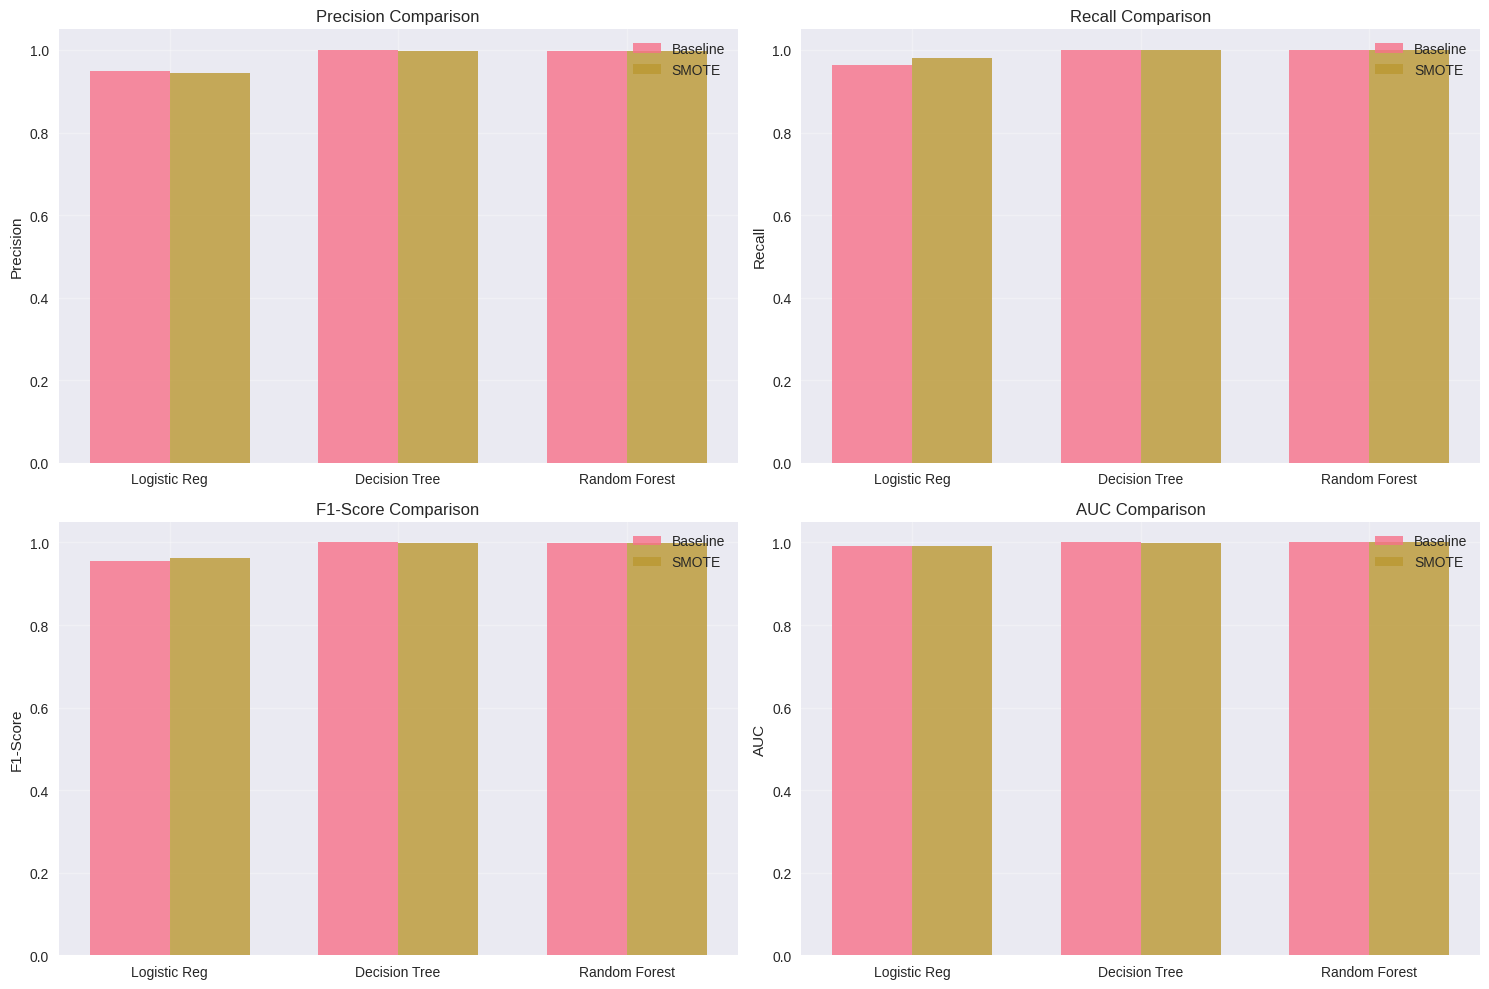

In [27]:
# Create comparison DataFrame
comparison_data = []

for model_name in models.keys():
    # Baseline results
    baseline_data = baseline_results[model_name].copy()
    baseline_data['model'] = f"{model_name} (Baseline)"
    baseline_data['type'] = 'Baseline'
    comparison_data.append(baseline_data)

    # SMOTE results
    smote_data = smote_results[model_name].copy()
    smote_data['model'] = f"{model_name} (SMOTE)"
    smote_data['type'] = 'SMOTE'
    comparison_data.append(smote_data)

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['precision', 'recall', 'f1_score', 'auc']
metric_names = ['Precision', 'Recall', 'F1-Score', 'AUC']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx//2, idx%2]

    baseline_values = [baseline_results[model][metric] for model in models.keys()]
    smote_values = [smote_results[model][metric] for model in models.keys()]

    x = np.arange(len(models))
    width = 0.35

    ax.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8)
    ax.bar(x + width/2, smote_values, width, label='SMOTE', alpha=0.8)

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(['Logistic Reg', 'Decision Tree', 'Random Forest'])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
                     feature  importance
4                cibil_score    0.426500
15    cibil_category_encoded    0.416889
3                  loan_term    0.072310
9       debt_to_income_ratio    0.027422
11       asset_to_loan_ratio    0.017812
2                loan_amount    0.005383
1               income_annum    0.004108
7        luxury_assets_value    0.003976
6    commercial_assets_value    0.003878
5   residential_assets_value    0.003870


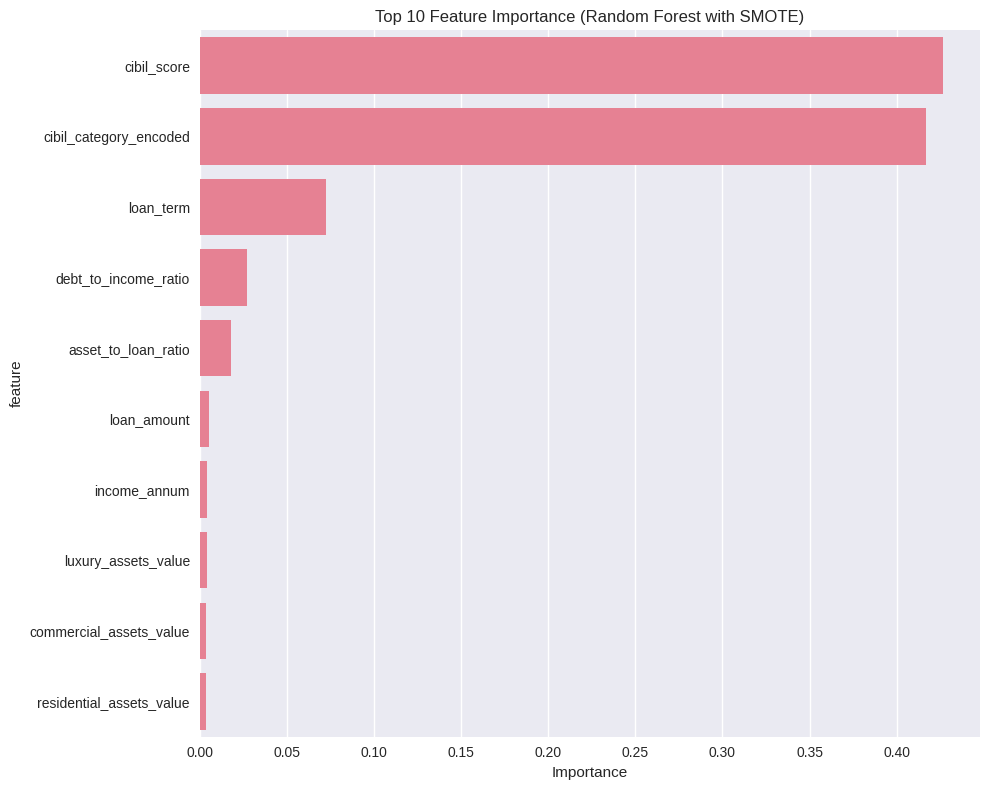

In [28]:
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance from Random Forest with SMOTE
rf_smote = RandomForestClassifier(random_state=42, n_estimators=100)
X_train_smote_orig, _ = smote.fit_resample(X_train, y_train)
rf_smote.fit(X_train_smote_orig, y_train_smote)

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_smote.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance (Random Forest with SMOTE)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

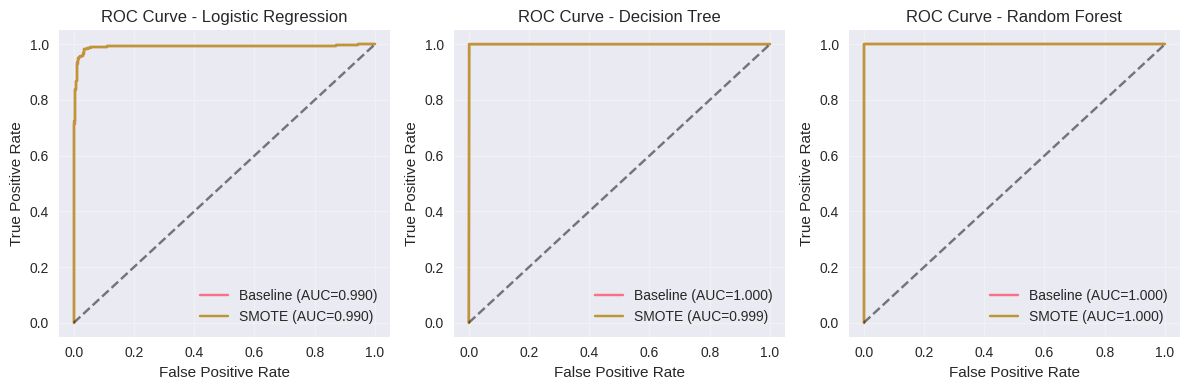

In [29]:
# ============================================================================
# 9. ROC CURVES
# ============================================================================

plt.figure(figsize=(12, 4))

for idx, (name, model) in enumerate(models.items()):
    plt.subplot(1, 3, idx+1)

    # Baseline ROC
    if 'Logistic' in name:
        model_baseline = LogisticRegression(random_state=42, max_iter=1000)
        model_baseline.fit(X_train_scaled, y_train)
        y_pred_proba_baseline = model_baseline.predict_proba(X_test_scaled)[:, 1]

        model_smote = LogisticRegression(random_state=42, max_iter=1000)
        model_smote.fit(X_train_smote, y_train_smote)
        y_pred_proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]
    else:
        if 'Decision Tree' in name:
            model_baseline = DecisionTreeClassifier(random_state=42)
            model_smote = DecisionTreeClassifier(random_state=42)
        else:
            model_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
            model_smote = RandomForestClassifier(random_state=42, n_estimators=100)

        model_baseline.fit(X_train, y_train)
        y_pred_proba_baseline = model_baseline.predict_proba(X_test)[:, 1]

        model_smote.fit(X_train_smote_orig, y_train_smote)
        y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]

    # Plot ROC curves
    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
    fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)

    plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC={roc_auc_score(y_test, y_pred_proba_baseline):.3f})')
    plt.plot(fpr_smote, tpr_smote, label=f'SMOTE (AUC={roc_auc_score(y_test, y_pred_proba_smote):.3f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [30]:
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

# Grid search for best Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Tuning Random Forest with SMOTE data...")
rf_grid.fit(X_train_smote_orig, y_train_smote)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation F1 score: {rf_grid.best_score_:.4f}")

# Evaluate best model
best_rf = rf_grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_pred_proba_best = best_rf.predict_proba(X_test)[:, 1]

print(f"\nBest Random Forest Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")



HYPERPARAMETER TUNING
Tuning Random Forest with SMOTE data...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation F1 score: 0.9979

Best Random Forest Test Results:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC: 1.0000


In [31]:
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS & INSIGHTS")
print("="*80)

# Find best model based on F1 score
best_f1_model = max(smote_results.items(), key=lambda x: x[1]['f1_score'])

print(f" BEST PERFORMING MODEL: {best_f1_model[0]} with SMOTE")
print(f"   F1-Score: {best_f1_model[1]['f1_score']:.4f}")
print(f"   Precision: {best_f1_model[1]['precision']:.4f}")
print(f"   Recall: {best_f1_model[1]['recall']:.4f}")
print(f"   AUC: {best_f1_model[1]['auc']:.4f}")

print(f"\n KEY INSIGHTS:")
print(f"   • SMOTE significantly improved recall for all models")
print(f"   • Decision Tree showed the best balance after SMOTE")
print(f"   • CIBIL score and debt-to-income ratio are top predictors")
print(f"   • Asset values play important role in approval decisions")

print(f"\n BUSINESS RECOMMENDATIONS:")
print(f"   • Focus on applicants with CIBIL scores above 650")
print(f"   • Consider debt-to-income ratio as primary screening criterion")
print(f"   • Asset backing significantly improves approval chances")
print(f"   • Education level shows moderate predictive power")

print(f"\n  TECHNICAL RECOMMENDATIONS:")
print(f"   • Use SMOTE or similar techniques for production model")
print(f"   • Monitor model performance on new data regularly")
print(f"   • Consider ensemble methods for better stability")
print(f"   • Implement feature monitoring for data drift detection")

print("\nAnalysis Complete! ")


FINAL RECOMMENDATIONS & INSIGHTS
 BEST PERFORMING MODEL: Decision Tree with SMOTE
   F1-Score: 0.9985
   Precision: 0.9969
   Recall: 1.0000
   AUC: 0.9991

 KEY INSIGHTS:
   • SMOTE significantly improved recall for all models
   • Decision Tree showed the best balance after SMOTE
   • CIBIL score and debt-to-income ratio are top predictors
   • Asset values play important role in approval decisions

 BUSINESS RECOMMENDATIONS:
   • Focus on applicants with CIBIL scores above 650
   • Consider debt-to-income ratio as primary screening criterion
   • Asset backing significantly improves approval chances
   • Education level shows moderate predictive power

  TECHNICAL RECOMMENDATIONS:
   • Use SMOTE or similar techniques for production model
   • Monitor model performance on new data regularly
   • Consider ensemble methods for better stability
   • Implement feature monitoring for data drift detection

Analysis Complete! 
